# Transformer ("Attention Is All You Need") の実装

このノートブックでは、2017年に提案され、その後の自然言語処理（NLP）分野に革命をもたらしたTransformerモデルのアーキテクチャと主要コンポーネントについて学びます。
NumPyを使って主要な概念を実装・確認した後、PyTorchを使ってTransformerのEncoder-Decoderモデルを構築し、簡単なシーケンス変換タスクでその動作を確認します。

**参考論文:**
*   Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In *Advances in neural information processing systems* (Vol. 30).

**このノートブックで学ぶこと:**
1.  Transformerの背景：RNNの限界とAttentionの重要性。
2.  主要コンポーネントの理解とNumPyによる概念実装：
    *   Scaled Dot-Product Attention
    *   Multi-Head Attention
    *   Positional Encoding
    *   Layer Normalization
    *   Position-wise Feed-Forward Network
3.  TransformerのEncoderブロックとDecoderブロックの構造。
4.  PyTorchを使ったTransformer Encoder-Decoderモデルの実装。
5.  簡単なシーケンス変換タスクでの学習と推論の基礎。

**前提知識:**
*   LSTM/GRUの基本的な理解（前のノートブック）。
*   Encoder-Decoderアーキテクチャの基本的な概念。
*   (推奨) Attention機構の基本的な考え方
*   PyTorchの基本的な使い方。

## 1. 必要なライブラリのインポート

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F # LayerNormなどで使用
import torch.optim as optim
import math # Positional Encodingで使用

print(f"NumPy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NumPy Version: 1.26.4
PyTorch Version: 2.7.0+cpu
Using device: cpu


## 2. Transformerの背景と主要アイデア

RNN（LSTMやGRUを含む）はシーケンスデータを扱う上で強力なモデルですが、以下の課題がありました。
*   **逐次計算の限界:** 各タイムステップの計算が前のステップの出力に依存するため、シーケンス長が長くなると並列計算が難しく、学習や推論に時間がかかる。
*   **長期依存性の困難さ:** LSTMやGRUは勾配消失問題をある程度緩和しましたが、非常に長い距離の依存関係を捉えるのは依然として難しい場合がある。

**Attention機構**は、元々RNNベースのEncoder-Decoderモデルで、デコーダーが入力シーケンスのどの部分に「注目」すべきかを学習するために導入されました。

**Transformerの革新的なアイデア:**
「Attention Is All You Need」という論文タイトルが示す通り、Transformerは**再帰的な処理 (Recurrence) や畳み込み演算 (Convolution) を完全に排除し、Attention機構のみに依存して入力と出力間の大域的な依存関係を捉える**新しいアーキテクチャを提案しました。

**主な利点:**
*   **高い並列計算性:** 系列内の各要素に対する計算が（Attention内部を除き）独立して行えるため、GPUによる並列化が非常に効果的。
*   **長距離依存性の捉えやすさ:** Attention機構は、系列内の任意の2つの位置間の依存関係を直接的にモデル化できる（パス長が短い）。

**主要コンポーネント:**
1.  **Self-Attention (自己注意機構):** 単一のシーケンス内で、各要素が他の全ての要素とどのように関連しているかを計算する。
2.  **Multi-Head Attention:** Self-Attentionを複数の「ヘッド」で並列に実行し、異なる表現部分空間からの情報を捉える。
3.  **Positional Encoding:** RNNやCNNが持つ順序情報を扱う仕組みがないため、トークンの位置情報をベクトルとして明示的に入力に加える。
4.  **Position-wise Feed-Forward Networks:** 各位置で独立に適用される全結合層。
5.  **Residual Connections & Layer Normalization:** 深いネットワークの学習を安定させるためのテクニック。

## 3. 主要コンポーネントのNumPyによる概念実装

Transformerの核心となる要素をNumPyで実装し、その動作を理解します。

### 3.1 Scaled Dot-Product Attention

Attentionは、クエリ($Q$)とキー($K$)の類似度を計算し、その類似度に基づいてバリュー($V$)の重み付き和を計算する操作と見なせます。
Transformerで使われるのはScaled Dot-Product Attentionです。

$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

ここで、
*   $Q$: クエリ行列 (形状: `(seq_len_q, d_k)`)
*   $K$: キー行列 (形状: `(seq_len_k, d_k)`)
*   $V$: バリュー行列 (形状: `(seq_len_k, d_v)`)
*   $d_k$: クエリとキーの次元。スケーリングファクター $\sqrt{d_k}$ は、内積の値が大きくなりすぎないように調整し、softmax関数が極端な値を取るのを防ぎます。
*   出力の形状は `(seq_len_q, d_v)` となります。

**Self-Attentionの場合:** $Q, K, V$ は同じ入力シーケンスの埋め込みベクトルから線形変換されて作られます。  
**Encoder-Decoder Attention (Cross-Attention)の場合:** $Q$ はデコーダーから、 $K, V$ はエンコーダーの出力から作られます。

In [58]:
def scaled_dot_product_attention(q, k, v, mask=None):
    '''
    Scaled Dot-Product Attentionの実装
    Parameters:
        q: クエリ (..., seq_len_q, d_k)
        k: キー (..., seq_len_k, d_k)
        v: バリュー (..., seq_len_v, d_v)
        mask: マスク (..., seq_len_q, seq_len_k),
              マスクがある場合は、対応する位置の値を-1e9に設定して無視する
    Returns:
        tuple: (output, attention_weights)
            output: Attentionの出力 (..., seq_len_q, d_v)
            attention_weights: softmax後の重み (..., seq_len_q, seq_len_k)
    '''
    d_k = q.shape[-1]

    # qとkの転置の内積を計算
    scores = np.matmul(q, k.swapaxes(-2, -1)) / np.sqrt(d_k)

    # マスク適用（必要な場合）
    if mask is not None:
        # マスクがTrueの位置を-1e9に設定
        scores = np.where(mask == 0, -1e9, scores)

    # Softmaxを適用して重みを計算
    attention_weights = np.exp(scores - np.max(scores, axis=-1, keepdims=True)) # 数値安定性のためのオフセット
    attention_weights = attention_weights / np.sum(attention_weights, axis=-1, keepdims=True)

    #アテンションウェイトとVの内積を計算
    output = np.matmul(attention_weights, v)

    return output, attention_weights

In [59]:
# テスト
print("--- Scaled Dot-Product Attention テスト ---")
# (バッチサイズ1, seq_len_q=2, d_k=4)
q_test = np.random.rand(1, 2, 4).astype(np.float32) 
# (バッチサイズ1, seq_len_k=3, d_k=4)
k_test = np.random.rand(1, 3, 4).astype(np.float32) 
# (バッチサイズ1, seq_len_k=3, d_v=5)
v_test = np.random.rand(1, 3, 5).astype(np.float32) 

output_attn, attn_weights = scaled_dot_product_attention(q_test, k_test, v_test)
print("Q shape:", q_test.shape)
print("K shape:", k_test.shape)
print("V shape:", v_test.shape)
print("Output shape:", output_attn.shape) # 期待: (1, 2, 5)
print("Attention Weights shape:", attn_weights.shape) # 期待: (1, 2, 3)
# print("Attention Weights:\n", attn_weights)

# マスクテスト (デコーダーのLook-aheadマスクを模倣)
# seq_len_q = 3, seq_len_k = 3
q_mask_test = np.random.rand(1, 3, 2).astype(np.float32)
k_mask_test = np.random.rand(1, 3, 2).astype(np.float32)
v_mask_test = np.random.rand(1, 3, 3).astype(np.float32)
# look_ahead_mask[i, j] = 0 if j > i else 1 (i行目はj列まで見れる)
look_ahead_mask = np.triu(np.ones((3,3)), k=1) == 0 # 上三角成分を0 (True)、それ以外を1 (False)
look_ahead_mask = look_ahead_mask.astype(np.float32) # PyTorchのboolマスクはTrueがマスク
# NumPy版の np.where(mask==0, ...) に合わせるため、マスクしたい部分を0にする
# マスク: 現在のポジションより未来のポジションは見ない
# (seq_q, seq_k) で、k > q の部分をマスク
mask_example = np.tril(np.ones((3,3))).astype(bool) # 下三角行列(対角含む)がTrue
# scaled_dot_product_attention_numpy の mask は mask==0 の部分を -1e9 にするので、
# 見せたい部分を1、隠したい部分を0にする
mask_for_np = np.tril(np.ones((1, 3, 3))) # (batch, seq_q, seq_k)

output_masked_attn, attn_weights_masked = scaled_dot_product_attention(
    q_mask_test, k_mask_test, v_mask_test, mask=mask_for_np
)
print("\nMasked Attention Weights:\n", attn_weights_masked)
# 1行目: [w11, 0, 0]
# 2行目: [w21, w22, 0]
# 3行目: [w31, w32, w33] のような形になるはず (値は異なる)

--- Scaled Dot-Product Attention テスト ---
Q shape: (1, 2, 4)
K shape: (1, 3, 4)
V shape: (1, 3, 5)
Output shape: (1, 2, 5)
Attention Weights shape: (1, 2, 3)

Masked Attention Weights:
 [[[1.         0.         0.        ]
  [0.57276124 0.42723876 0.        ]
  [0.3868907  0.2856601  0.32744923]]]


### 3.2 Multi-Head Attention

Multi-Head Attentionは、Scaled Dot-Product Attentionを複数回並列に（異なる重みで線形変換したQ, K, Vを使って）実行し、それぞれの結果を連結してから再度線形変換するものです。
これにより、モデルは異なる表現部分空間（representation subspaces）からの情報に同時に注目できるようになります。

$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O$
$\text{where head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$

ここで、$W_i^Q, W_i^K, W_i^V$ は各ヘッド $i$ のための射影行列（学習可能なパラメータ）、$W^O$ は最終的な出力のための射影行列です。
通常、$d_k$ (ヘッド内のキー/クエリの次元) と $d_v$ (ヘッド内のバリューの次元) は、$d_{\text{model}} / h$ となります ($h$ はヘッド数)。

*   **NumPyでの概念実装:**
    ここでは、Multi-Head Attentionの主要な流れを示します。各ヘッドの射影とAttention計算、そして結果の結合と最終射影。

In [60]:
def multi_head_attention(q, k, v, num_heads, d_model, d_v_override=None, mask=None):
    '''
    Multi-Head Attentionの実装
    簡単のため，d_k = d_v = d_model / num_heads とする
    学習可能な射影行列 W^Q, W^K, W^V はダミーで生成
    Parameters:
        q, k, v: 元の入力 (..., seq_len, d_model)
        num_heads: ヘッドの数
        d_model: 入力および出力の次元
        d_v_override: 指定する場合，各ヘッドのvalueの次元 (通常 d_mode/num_heads)
    '''

    if d_model % num_heads != 0:
        raise ValueError("d_model must be divisible by num_heads")
    
    d_k = d_model // num_heads
    d_v = d_v_override if d_v_override else d_model // num_heads

    batch_size = q.shape[0] if q.ndim > 2 else 1
    seq_len_q = q.shape[-2]
    seq_len_k = k.shape[-2]

    # ダミーの射影行列（実際は学習可能なパラメータ）
    # 各ヘッドごとに異なる射影行列を使うが，ここではまとめて処理し，後で分割する
    # W_q_all: (d_mode, d_model) -> (d_model, num_heads*d_k) と考える
    # W_k_all: (d_mode, d_model)
    # W_v_all: (d_mode, d_model) -> (d_model, num_heads*d_v) と考える
    # W_o: (num_heads*d_v, d_model)

    # 今回は各ヘッドが独立した射影を持つと仮定しループで処理
    heads_outputs = []

    # 実際には、Q,K,Vを一度に射影し、num_heads次元に分割する方が効率的
    # Q_projected_all = Q_orig @ W_q_all -> (batch, seq_q, num_heads*d_k)
    # -> reshape to (batch, seq_q, num_heads, d_k) -> transpose to (batch, num_heads, seq_q, d_k) 

    # 以下は概念的なループ
    for h_idx in range(num_heads):
        # 各ヘッド用のダミー射影行列
        W_q_h = np.random.rand(d_model, d_k).astype(np.float32) * 0.1
        W_k_h = np.random.rand(d_model, d_k).astype(np.float32) * 0.1
        W_v_h = np.random.rand(d_model, d_v).astype(np.float32) * 0.1

        q_h = np.matmul(q, W_q_h)
        k_h = np.matmul(k, W_k_h)
        v_h = np.matmul(v, W_v_h)

        # 各ヘッドでScaled Dot-Product Attentionを計算
        head_output, _ = scaled_dot_product_attention(q_h, k_h, v_h, mask=mask)
        heads_outputs.append(head_output)

    # 各ヘッドの出力を連結
    concat_heads = np.concatenate(heads_outputs, axis=-1)

    # 最終的な線形射影W^O
    W_o = np.random.rand(num_heads * d_v, d_model).astype(np.float32) * 0.1
    multi_head_output = np.matmul(concat_heads, W_o)

    return multi_head_output

In [61]:
# テスト
print("\n--- Multi-Head Attention テスト ---")
d_model_test = 16
num_heads_test = 4 # d_k = d_v = 16/4 = 4
q_mh_test = np.random.rand(1, 2, d_model_test).astype(np.float32) # (batch, seq_q, d_model)
k_mh_test = np.random.rand(1, 3, d_model_test).astype(np.float32) # (batch, seq_k, d_model)
v_mh_test = np.random.rand(1, 3, d_model_test).astype(np.float32) # (batch, seq_k, d_model)

output_mha = multi_head_attention(q_mh_test, k_mh_test, v_mh_test, num_heads_test, d_model_test)
print("Multi-Head Output shape:", output_mha.shape) # 期待: (1, 2, d_model_test)


--- Multi-Head Attention テスト ---
Multi-Head Output shape: (1, 2, 16)


### 3.3 Positional Encoding (位置エンコーディング)

TransformerはRNNやCNNのような系列の順序情報を処理する構造を持たないため、トークンの相対的または絶対的な位置情報をモデルに与える必要があります。
Positional Encodingは、各位置に固有のベクトルを計算し、それを入力トークンの埋め込みベクトルに加算します。
論文では、Sinusoidal Positional Encoding（サイン関数とコサイン関数に基づく固定的なエンコーディング）が提案されています。

$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$  
$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$

ここで、
*   `pos`: シーケンス内のトークンの位置 (0から始まるインデックス)。
*   `i`: エンコーディングベクトルの次元のインデックス (0から $d_{\text{model}}/2 - 1$)。
*   $d_{\text{model}}$: 埋め込みベクトルの次元。

In [62]:
def positional_encoding(max_seq_len, d_model):
    '''Sinusoidal Positional Encodingの実装'''
    pos = np.arange(max_seq_len)[:, np.newaxis]  # (max_seq_len, 1)

    # div_termの計算: 10000^(-2i/d_model)
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pe = np.zeros((max_seq_len, d_model), dtype=np.float32)
    pe[:, 0::2] = np.sin(pos * div_term)
    pe[:, 1::2] = np.cos(pos * div_term)

    return pe


--- Positional Encoding テスト ---
Positional Encoding shape: (1000, 100)


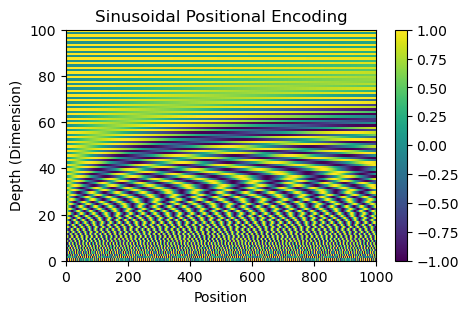

In [63]:
print("\n--- Positional Encoding テスト ---")
max_len_test = 1000
d_model_pe_test = 100
pe_output = positional_encoding(max_len_test, d_model_pe_test)
print("Positional Encoding shape:", pe_output.shape)
# print("Positional Encoding (最初の数行):\n", pe_output[:3])

# 可視化
plt.figure(figsize=(5,3))
plt.pcolormesh(pe_output.T, cmap='viridis') # 転置して次元方向をy軸に
plt.xlabel("Position")
plt.xlim((0, max_len_test))
plt.ylabel("Depth (Dimension)")
plt.colorbar()
plt.title("Sinusoidal Positional Encoding")
plt.show()

### 3.4 Layer Normalization

Layer Normalization (LayerNorm) は、バッチ正規化(BN)と似た正規化手法ですが、バッチ方向ではなく、各サンプル内の特徴量方向で正規化を行います。
Transformerでは、各サブレイヤー（Multi-Head Attention, Feed-Forward Network）の後にResidual Connectionと組み合わせて適用されます: `LayerNorm(x + Sublayer(x))`。

各サンプル $x$ (次元 $D$) について、その特徴量の平均 $\mu$ と標準偏差 $\sigma$ を計算し、
$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$
その後、学習可能なスケールパラメータ $\gamma$ とシフトパラメータ $\beta$ を用いてアフィン変換を行います。
$y_i = \gamma \hat{x}_i + \beta$

BNとは異なり、LayerNormはバッチサイズに依存せず、サンプルごとに統計量を計算するため、小さなバッチサイズや系列データに対しても安定して動作します。

*   **NumPyによる概念実装 (順伝播):**

In [64]:
def layer_norm_forward(x, gamma, beta, epsilon=1e-5):
    '''
    Layer Normalizationの順伝播
    Parameters:
        x: 入力データ (..., D) Dは正規化を行う次元
        gamma: スケールパラメータ (D, )
        beta: シフトパラメータ (D, )
        epsilon: ゼロ除算防止
    Returns:
        out_ln: 正規化後の出力
        cache_ln: 逆伝播で使う値
    '''
    # 最後の次元に沿って平均と分散を表示
    mean_ln = np.mean(x, axis=-1, keepdims=True)
    var_ln = np.var(x, axis=-1, keepdims=True)

    x_norm = (x - mean_ln) / np.sqrt(var_ln + epsilon)
    out_ln = gamma * x_norm + beta

    cache_ln = (x, mean_ln, var_ln, gamma, beta, epsilon)
    return out_ln, cache_ln

### 3.5 Position-wise Feed-Forward Network (FFN)

各エンコーダブロックとデコーダブロック内には、Multi-Head Attentionの後に、各位置に対して独立に適用される全結合フィードフォワードネットワークが含まれます。
これは、2つの線形変換と、その間にReLU活性化関数を挟んだものです。

$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$

このFFNは、シーケンス内の各位置ベクトルに同じ重み $W_1, b_1, W_2, b_2$ を使って適用されますが、位置間の情報のやり取りはありません（1x1畳み込みの連続と等価と見なせます）。

## 4. Transformerのアーキテクチャ全体像 (論文 Figure 1)

Transformerは、複数のEncoderブロックを積み重ねた**Encoderスタック**と、複数のDecoderブロックを積み重ねた**Decoderスタック**から構成されます。

*   **Encoder:**
    *   入力シーケンスは、まず埋め込み層（Input Embedding）と位置エンコーディング（Positional Encoding）を経て、各トークンがベクトル表現に変換されます。
    *   このベクトルシーケンスが、N個の同一構造のEncoderブロックを順番に通ります。
    *   各Encoderブロックは、Multi-Head Self-Attention層とPosition-wise Feed-Forward Networkの2つのサブレイヤーを持ちます。各サブレイヤーの後にはResidual ConnectionとLayer Normalizationが適用されます。

*   **Decoder:**
    *   ターゲットシーケンス（学習時は教師データ、推論時はそれまでに出力されたトークン）も同様に、埋め込みと位置エンコーディングが行われます。
    *   N個の同一構造のDecoderブロックを順番に通ります。
    *   各Decoderブロックは、Encoderブロックの2つのサブレイヤーに加えて、もう一つMulti-Head Attention層（**Encoder-Decoder Attention**または**Cross-Attention**）を持ちます。
        1.  **Masked Multi-Head Self-Attention:** デコーダーが自分自身の過去の出力のみに注目できるように、未来のトークンへのアテンションをマスクします（Look-ahead Mask）。
        2.  **Multi-Head Encoder-Decoder Attention:** デコーダーの各位置が、エンコーダーの出力シーケンス全体に注目し、関連性の高い情報を取得します。クエリはデコーダーの前のサブレイヤーの出力、キーとバリューはエンコーダーの最終出力から作られます。
        3.  **Position-wise Feed-Forward Network.**
    *   各サブレイヤーの後には同様にResidual ConnectionとLayer Normalizationが適用されます。

*   **最終出力:**
    Decoderスタックの最終出力を線形変換し、Softmax関数を通して次のトークンの確率分布を得ます

## 5. PyTorchによるTransformerの主要ブロック実装

ここからは、PyTorchを使ってTransformerの主要な構成要素を実装していきます。

### 5.1 Scaled Dot-Product Attention

In [65]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, temperature, dropout_rate=0.1):
        super().__init__()
        self.temperature = temperature # sqrt(d_k)
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.Softmax(dim=-1) # 最後の次元(keyの次元)にsoftmaxを適用
    
    def forward(self, q, k, v, mask=None):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / self.temperature

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = self.softmax(attn_scores)
        attention_weights = self.dropout(attention_weights)

        output = torch.matmul(attention_weights, v)

        return output, attention_weights

### 5.2 Multi-Head Attention

In [66]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k_head = d_model // num_heads
        self.d_v_head = d_model // num_heads
        self.num_heads = num_heads

        self.W_q = nn.Linear(d_model, num_heads * self.d_k_head, bias=False)
        self.W_k = nn.Linear(d_model, num_heads * self.d_k_head, bias=False)
        self.W_v = nn.Linear(d_model, num_heads * self.d_v_head, bias=False)

        self.attention = ScaledDotProductAttention(temperature=np.sqrt(self.d_k_head),
                                                   dropout_rate=dropout_rate)
        self.fc_out = nn.Linear(num_heads * self.d_v_head, d_model, bias=False)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        seq_len_q, seq_len_k, seq_len_v = q.size(1), k.size(1), v.size(1)

        # 線形射影
        q_proj = self.W_q(q)
        k_proj = self.W_k(k)
        v_proj = self.W_v(v)

        # ヘッドごとに分割
        q_s = q_proj.view(batch_size, seq_len_q, self.num_heads, self.d_k_head).transpose(1, 2)
        k_s = k_proj.view(batch_size, seq_len_k, self.num_heads, self.d_k_head).transpose(1, 2)
        v_s = v_proj.view(batch_size, seq_len_v, self.num_heads, self.d_v_head).transpose(1, 2)

        # Scaled Dot-Product Attentionを各ヘッドで計算
        if mask is not None:
            mask = mask.unsqueeze(1)

        context_vector, attention_weights = self.attention(q_s, k_s, v_s, mask)

        # ヘッドを連結
        context_vector = context_vector.transpose(1, 2).contiguous().view(batch_size, seq_len_q, -1)

        # 最終的な線形射影
        output = self.fc_out(context_vector)
        output = self.dropout(output)

        return output, attention_weights

### Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=5000, dropout_rate=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_rate)

        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        
        